In [21]:
"""
Fractional Loss Functions - PyTorch Example

This script demonstrates linear regression using various robust loss functions,
including standard robust losses (L2, Cauchy, Welsch, Geman–McClure, log-cosh) and
our proposed fractional losses.

Note:
    This code builds upon Jon Barron's code in "A General and Adaptive Robust Loss Function" 
    available at: https://github.com/jonbarron/robust_loss_pytorch

It corresponds to our work:
    "When Fractional Calculus Meets Robust Learning: Adaptive Robust Loss Functions"
"""

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn

# Import fractional loss implementations.
from fractional_logcosh_loss import FractionalLogCoshLoss  # Class implementation for fractional logcosh loss.
from fractional_L2_loss import FractionalL2Loss             # Class implementation for fractional L2 loss.
from fractional_cauchy_loss import FractionalCauchyLoss  # Class implementation for fractional Cauchy loss.
from util import inv_affine_sigmoid, affine_sigmoid

# -----------------------------------------------------------------------------
# Loss Function Selection
# -----------------------------------------------------------------------------
# Set loss_function_name to one of:
# "L2", "huber", "L1", "fractional_L2_loss", "fractional_logcosh", "fractional_cauchy_loss"

# For example you can try 'L2' and observe biased regression, then try 'fractional_L2_loss' to observe robust regression.
loss_function_name = "fractional_L2_loss"  # <-- Change as desired

use_fractional = loss_function_name in ["fractional_logcosh_loss", "fractional_L2_loss", "fractional_cauchy_loss"]

# Parameters for fractional losses.
n_memory = 10
h = 0.1

# Bounds for learnable parameters.
alpha_lo, alpha_hi = 0.0, 1.0
scale_lo, scale_hi = 0.0, 1.0

if use_fractional:
    
        latent_alpha = torch.nn.Parameter(torch.tensor([0.01], dtype=torch.float32))
        latent_scale = torch.nn.Parameter(torch.tensor([1], dtype=torch.float32))
        
        if loss_function_name == "fractional_logcosh_loss":
            fractional_logcosh_module = FractionalLogCoshLoss(n_memory=n_memory, h=h, device='cpu')
            fractional_logcosh_module.latent_alpha = latent_alpha
            fractional_logcosh_module.latent_c = latent_scale
            loss_fn = lambda y_pred, y_true: torch.mean(
                fractional_logcosh_module(y_pred, y_true)
            )
        elif loss_function_name == "fractional_L2_loss":
            fractional_l2_module = FractionalL2Loss()
            fractional_l2_module.latent_alpha = latent_alpha
            fractional_l2_module.latent_c = latent_scale
            loss_fn = lambda y_pred, y_true: torch.mean(
                fractional_l2_module(y_pred, y_true)
            )
        elif loss_function_name == "fractional_cauchy_loss":
            fractional_cauchy_module = FractionalCauchyLoss(n_memory=n_memory, h=h, device='cpu')
            fractional_cauchy_module.latent_alpha = latent_alpha
            fractional_cauchy_module.latent_c = latent_scale
            loss_fn = lambda y_pred, y_true: torch.mean(
                fractional_cauchy_module(y_pred, y_true)
            )
else:
    if loss_function_name == "L2":
        loss_fn = nn.MSELoss()
    elif loss_function_name == "L1":
        loss_fn = nn.L1Loss()
    elif loss_function_name == "huber":
        loss_fn = nn.HuberLoss(delta=10)

# -----------------------------------------------------------------------------
# Data Generation: Create Regression Data with Outliers
# -----------------------------------------------------------------------------
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15

x_np = np.random.uniform(size=n)
y_np = scale_true * x_np + shift_true
y_np += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y_np = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y_np - 0.5)), y_np)

x = torch.Tensor(x_np)
y = torch.Tensor(y_np)

# -----------------------------------------------------------------------------
# Model Definition: Simple Linear Regression
# -----------------------------------------------------------------------------
class RegressionModel(nn.Module):
    """A simple linear regression model."""
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x[:, None])[:, 0]

def plot_regression(regression, x, y, scale_true, shift_true):
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()

    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, label='Data')
    plt.plot(x_plot, y_plot, 'r', label='Model Prediction')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Regression Fit')
    plt.legend()
    plt.show()


Epoch    0: Loss = 0.039108  Alpha = 0.500000  Scale = 0.729088
Epoch  100: Loss = 0.023616  Alpha = 0.376590  Scale = 0.503738
Epoch  200: Loss = 0.018184  Alpha = 0.484855  Scale = 0.245780
Epoch  300: Loss = 0.008217  Alpha = 0.759164  Scale = 0.084351
Epoch  400: Loss = 0.003893  Alpha = 0.859097  Scale = 0.039279
Epoch  500: Loss = 0.002357  Alpha = 0.896964  Scale = 0.023780
Epoch  600: Loss = 0.001632  Alpha = 0.916772  Scale = 0.016400
Epoch  700: Loss = 0.001222  Alpha = 0.929147  Scale = 0.012185
Epoch  800: Loss = 0.000963  Alpha = 0.937733  Scale = 0.009499
Epoch  900: Loss = 0.000788  Alpha = 0.944112  Scale = 0.007659
Epoch 1000: Loss = 0.000662  Alpha = 0.949084  Scale = 0.006331
Epoch 1100: Loss = 0.000568  Alpha = 0.953100  Scale = 0.005334
Epoch 1200: Loss = 0.000496  Alpha = 0.956435  Scale = 0.004563
Epoch 1300: Loss = 0.000439  Alpha = 0.959264  Scale = 0.003951
Epoch 1400: Loss = 0.000393  Alpha = 0.961706  Scale = 0.003457
Epoch 1500: Loss = 0.000356  Alpha = 0.9

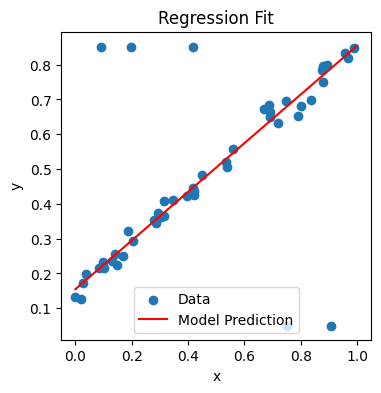

In [22]:
# -----------------------------------------------------------------------------
# Training Loop
# -----------------------------------------------------------------------------
num_epochs = 2000
regression = RegressionModel()

if use_fractional:
        optimizer = torch.optim.Adam(
            list(regression.parameters()) + [latent_alpha, latent_scale],
            lr=0.01
        )
else:
    optimizer = torch.optim.Adam(regression.parameters(), lr=0.01)

for epoch in range(num_epochs):
    y_pred = regression(x)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        if use_fractional:
                current_alpha = affine_sigmoid(latent_alpha, alpha_lo, alpha_hi).item()
                current_scale = affine_sigmoid(latent_scale, scale_lo, scale_hi).item()
                print(f"Epoch {epoch:4d}: Loss = {loss.item():.6f}  Alpha = {current_alpha:.6f}  Scale = {current_scale:.6f}")
        else:
            print(f"Epoch {epoch:4d}: Loss = {loss.item():.6f}")

# -----------------------------------------------------------------------------
# Plot Results
# -----------------------------------------------------------------------------
plot_regression(regression, x, y, scale_true, shift_true)